# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


The goals of the project are:
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report


## Import Packages

In [1]:
#importing some useful packages To install opencv use: conda install -c menpo opencv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


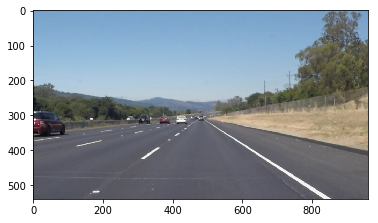

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def bgr2gray(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def text_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
            
    
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def sort_and_average_lines(lines):
    l_segments = np.empty((3,0)) #arrays of (slope, intercept, length)
    r_segments = np.empty((3,0))
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y1 == y2) or (x1 == x2)):
                continue # will ignore vertical or horizontal lines
            slope = ((y2-y1)/(x2-x1))
            length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            intercept = y1 - slope*x1
            A = np.array([slope, intercept, length])
            if slope > 0: # right line
                 r_segments = np.concatenate((r_segments, A[:,None]), 1)
            if slope < 0: # left line
                l_segments = np.concatenate((l_segments, A[:,None]), 1)
    #compute slopes and intercepts. through away outliers
    #this was never implemented
    #averaging with weights. As a weight we take length of the segment
    r_weights = r_segments[2,:]/ np.sum(r_segments[2,:])
    l_weights = l_segments[2,:]/ np.sum(l_segments[2,:])
    
    r_line = np.sum(r_segments[[0,1],:]*r_weights, 1)
    l_line = np.sum(l_segments[[0,1],:]*l_weights, 1)
    
    return  r_line, l_line


## ImplementationI have in mind
#### read image
#### convert to gray scale
#### apply gaussian smoothing
#### apply canny filter
#### apply a polygon
Note, that in the case one first applies a polygon mask, and then canny, there always will be an issue with detecting a border of the polygon as an edge due to shart threshold from image to black color. It can be bypassed by removing lines that have same parameters as a polygon boarders. I did not go ths way though, in order not degress too much from the pain task. However, there might be a benefit in speeding up the computation with custom Canny filter that would ignore basked out area.
### find lines in hough space

In [4]:
# solidYellowCurve.jpg' - done
#  'solidYellowLeft.jpg' - done
#  'solidYellowCurve2.jpg' - done
#  'solidWhiteRight.jpg' - done
#  'whiteCarLaneSwitch.jpg' - done
#  'solidWhiteCurve.jpg - done

def lineDetector(image, SHOW):
    #printing out some stats and plotting
    if (SHOW):
        print('This image is:', type(image), 'with dimensions:', image.shape)
        plt.figure()
        plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
        plt.xlabel('original')

    wim = image.copy() # copy the image for processing
    wim = grayscale(wim)#convert to grayscale
    if (SHOW):
        plt.figure()
        plt.imshow(wim, cmap='gray')
        plt.xlabel('copy')

    CLT = 50 #apply canny filter
    CHT = 140
    wimC = canny(wim, CLT, CHT)
    if (SHOW):
        plt.figure()
        plt.imshow(wimC, cmap='gray')
        plt.xlabel('ccanny')

    wimSize = wim.shape #apply a prism-shaped polygon
    FORy = 325
    FOR = [(100, wimSize[0]),\
            (460, FORy),\
            (510, FORy),\
            (905, wimSize[0])]
    vertices = np.array([FOR], dtype = np.int32)
    masked_canny = region_of_interest(wimC, vertices)
    if (SHOW):
        plt.figure()
        plt.imshow(masked_canny, cmap='gray')
        plt.xlabel(' masked canny')

    #search for lines in hough space
    rho = 2               # distance resolution in pixels of the Hough grid
    theta = 2*np.pi/180   # angular resolution in radians of the Hough grid
    VotesThreshold = 6    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 3   #minimum number of pixels making up a line
    max_line_gap = 1      # maximum gap in pixels between connectable line segments
    blank = np.copy(masked_canny)*0 # creating a blank to draw lines on

    wimLines = hough_lines(masked_canny, rho, theta, VotesThreshold, min_line_length, max_line_gap)
    final = weighted_img(wimLines, image, α=0.8, β=1., γ=0.)
    
#     plt.figure()
#     plt.imshow(final)
#     plt.xlabel('Initial image with lines superimposed')
    return final
    #    return text_lines(masked_canny, rho, theta, VotesThreshold, min_line_length, max_line_gap)

 


#Test of the function:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
lines = lineDetector(image, False)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
ImList = os.listdir("test_images/")
ImList = [f for f in ImList if not f.startswith('.')]

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [6]:
ImList

['Screen Shot 2018-05-09 at 4.18.39 PM.jpeg',
 'solidYellowCurve.jpg',
 'Screen Shot 2018-05-09 at 3.57.13 PM.jpeg',
 'solidYellowLeft.jpg',
 'Screen Shot 2018-05-09 at 4.19.56 PM.jpeg',
 'Screen Shot 2018-05-09 at 3.56.16 PM.jpeg',
 'solidYellowCurve2.jpg',
 'Screen Shot 2018-05-09 at 3.54.34 PM.jpg',
 'Screen Shot 2018-05-09 at 4.16.16 PM.jpeg',
 'solidWhiteRight.jpg',
 'Screen Shot 2018-05-10 at 3.59.43 PM.jpg',
 'Screen Shot 2018-05-09 at 4.17.37 PM.jpeg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

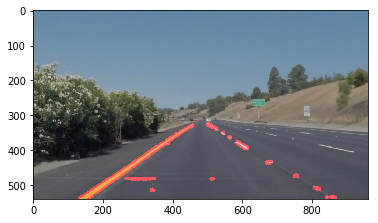

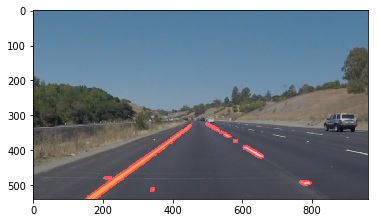

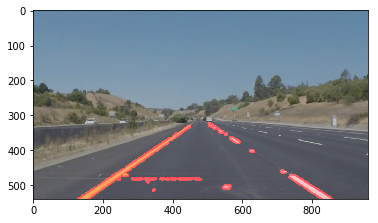

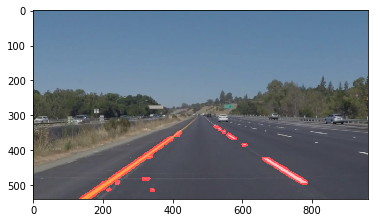

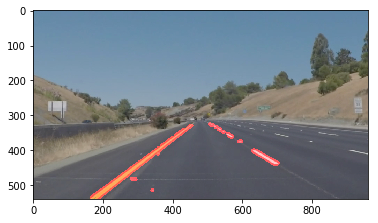

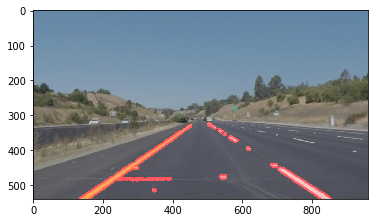

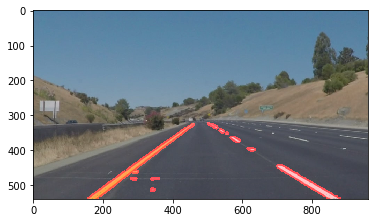

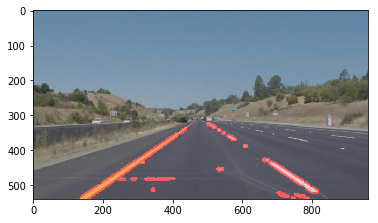

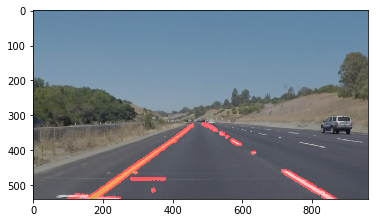

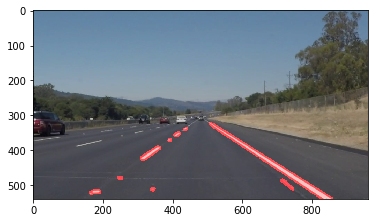

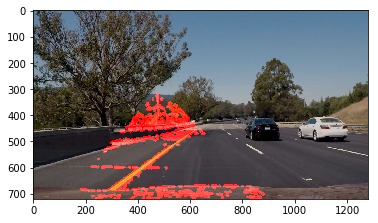

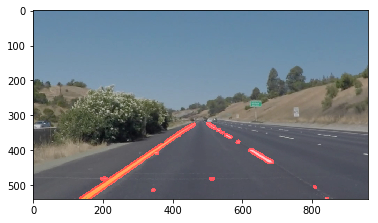

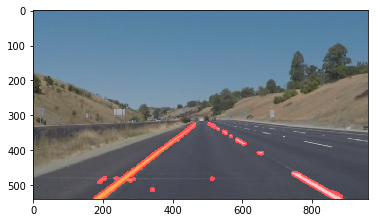

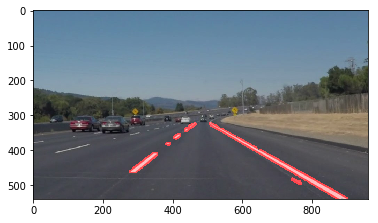

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
#image = mpimg.imread('test_images/'+ImList[0])
for image in ImList:
    im = mpimg.imread('test_images/'+image)
    processedImg = lineDetector(im, False)
    plt.figure()
    plt.imshow(processedImg) 
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

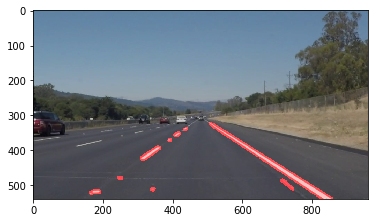

In [9]:
def process_image(image):
    return lineDetector(image, False)
#This function is defined above
# result = lineDetector(im, SHOW)
# im - color image
# SHOW - boolean: plots all intermediate steps if Ture and plots only result if False. This is for debugging.
# result - color image im with detected lines superimposed
image = mpimg.imread('test_images/solidWhiteRight.jpg')
A = process_image(image)
plt.figure()
plt.imshow(A)
#plt.xlabel('Initial image with lines superimposed')

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'test_videos_output/solidYellowLeft_initial.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
print('done')

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_initial.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_initial.mp4


100%|█████████▉| 681/682 [00:07<00:00, 89.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_initial.mp4 

CPU times: user 6.18 s, sys: 802 ms, total: 6.99 s
Wall time: 8.03 s
done


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

## modification of the process_image function. The purpose of the modification is to add a part which averages the segments of the lines and draws a solid lines on the picture/video

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


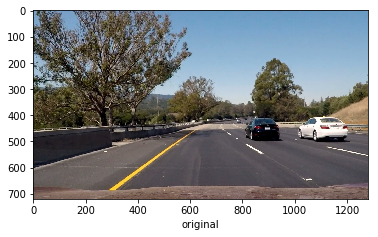

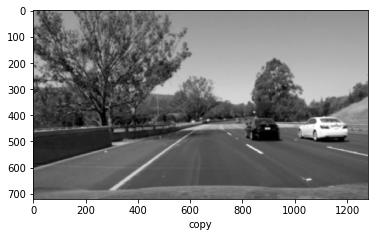

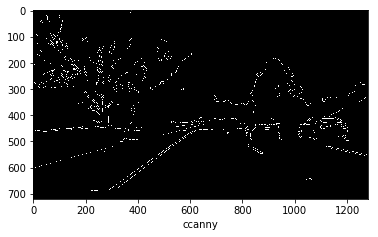

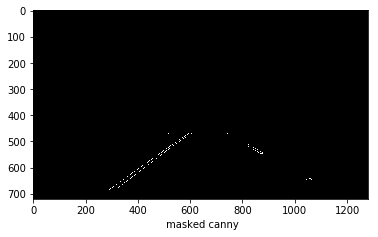

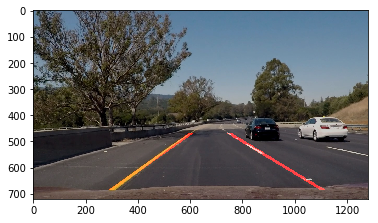

In [12]:
# solidYellowCurve.jpg' - done
#  'solidYellowLeft.jpg' - done
#  'solidYellowCurve2.jpg' - done
#  'solidWhiteRight.jpg' - done
#  'whiteCarLaneSwitch.jpg' - done
#  'solidWhiteCurve.jpg - done

#changes in this function:
# a) changed teh way ROI is defined, instead of numbers fraction of the frame size
# b) added gaussian smoothing of the image
def lineDetectorImproved(image, SHOW):
    #printing out some stats and plotting
    if (SHOW):
        print('This image is:', type(image), 'with dimensions:', image.shape)
        plt.figure()
        plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
        plt.xlabel('original')

    wim = image.copy() # copy the image for processing
    wim = grayscale(wim)#convert to grayscale       
    wim = gaussian_blur(wim, 13)
    if (SHOW):
        plt.figure()
        plt.imshow(wim, cmap='gray')
        plt.xlabel('copy')
        
    CLT = 50 #apply canny filter
    CHT = 150
    wimC = canny(wim, CLT, CHT)
    if (SHOW):
        plt.figure()
        plt.imshow(wimC, cmap='gray')
        plt.xlabel('ccanny')

    ysize, xsize = wim.shape #apply a prism-shaped polygon

    bottom_left  = [xsize*0.1, ysize*0.95]
    top_left     = [xsize*0.4, ysize*0.65]
    bottom_right = [xsize*0.95, ysize*0.95]
    top_right    = [xsize*0.6, ysize*0.65] 
    FOR = [bottom_left,\
           top_left,\
           top_right,\
           bottom_right] 
    vertices = np.array([FOR], dtype = np.int32)
    masked_canny = region_of_interest(wimC, vertices)
    if (SHOW):
        plt.figure()
        plt.imshow(masked_canny, cmap='gray')
        plt.xlabel(' masked canny')

    #search for lines in hough space
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180   # angular resolution in radians of the Hough grid
    VotesThreshold = 10    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15   #minimum number of pixels making up a line
    max_line_gap = 300      # maximum gap in pixels between connectable line segments
    
    lines = cv2.HoughLinesP(masked_canny, rho, theta, VotesThreshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    averaged_lines = sort_and_average_lines(lines)
    #blank = np.copy(masked_canny)*0 # creating a blank to draw lines on
    #generate x1 y1 and x2 y2
    x1 = 0 
    y1 = averaged_lines[0][1]
    x2 = xsize
    y2 = xsize*averaged_lines[0][0] + averaged_lines[0][1]
    rightLine = [[int(x1), int(y1), int(x2), int(y2)]]
    
    x1 = 0 
    y1 = averaged_lines[1][1]
    x2 = xsize
    y2 = xsize*averaged_lines[1][0] + averaged_lines[1][1]
    leftLine = [[int(x1), int(y1), int(x2), int(y2)]]
    
    lines = [rightLine, leftLine]
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    masked_line_img = region_of_interest(line_img, vertices)
    final1 = weighted_img(masked_line_img, image, α=0.8, β=1., γ=0.)
    if (SHOW):
        plt.figure()
        plt.imshow(final1)
    return final1

 


#Test of the function:
image = mpimg.imread('test_images/Screen Shot 2018-05-10 at 3.59.43 PM.jpg')

lines = lineDetectorImproved(image, True)

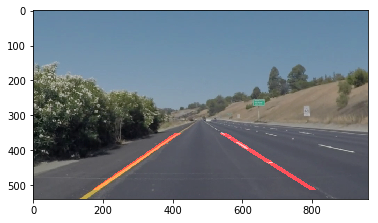

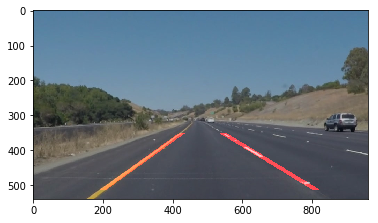

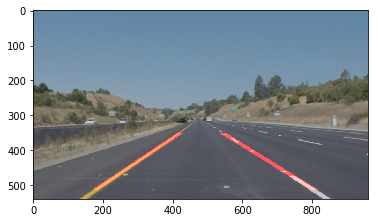

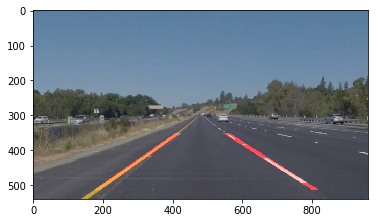

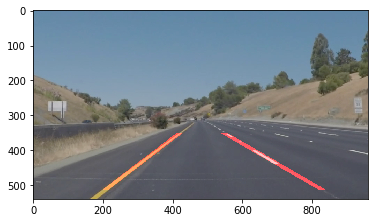

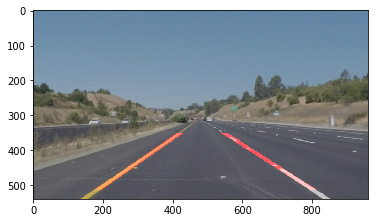

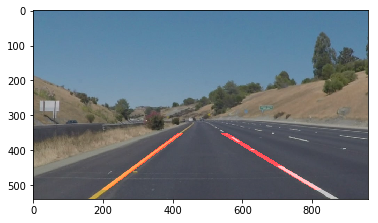

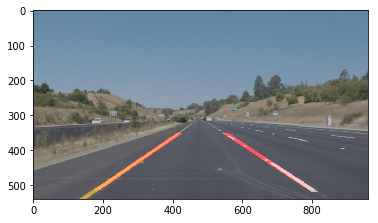

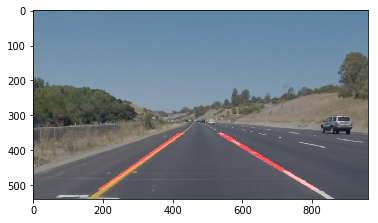

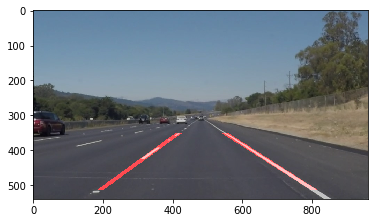

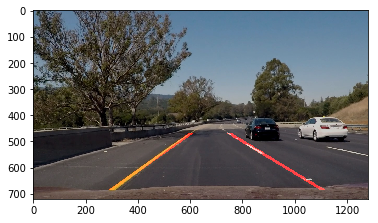

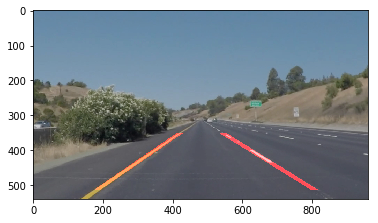

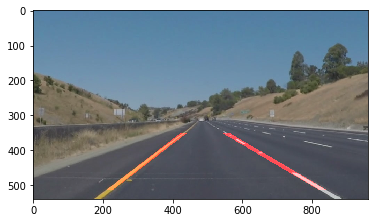

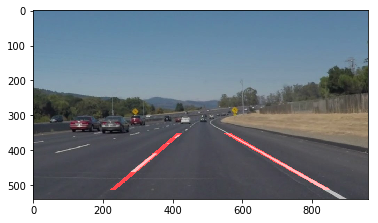

In [13]:
for image in ImList:
    im = mpimg.imread('test_images/'+image)
    plt.figure()
    plt.imshow(lineDetectorImproved(im, False))
    

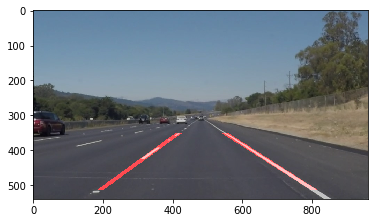

In [15]:
def process_imageImproved(image):
    return lineDetectorImproved(image, False)
#This function is defined above
# result = lineDetector(im, SHOW)
# im - color image
# SHOW - boolean: plots all intermediate steps if Ture and plots only result if False. This is for debugging.
# result - color image im with detected lines superimposed
image = mpimg.imread('test_images/solidWhiteRight.jpg')
A = process_imageImproved(image)
plt.figure()
plt.imshow(A)
#plt.xlabel('Initial image with lines superimposed')

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft_improved.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(16.5,20)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_imageImproved)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_improved.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_improved.mp4


100%|█████████▉| 681/682 [00:08<00:00, 83.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_improved.mp4 

CPU times: user 7.16 s, sys: 813 ms, total: 7.97 s
Wall time: 8.48 s
